##  Team 17, GMU ECE552 Big Data Technologies, Fall 2022 - Sai Jaswanth Kumar Kunku, Abhishek Godavarthi, Bhargav Teja Jakku

# Task 1: Data Preprocessing

### Importing Libraries

In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import *
from pyspark.sql import functions as f
#import pyspark.sql.functions as f
from pyspark.sql.window import Window
from pyspark.sql.types import *
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.ml.feature import VectorAssembler
#from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier,DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


sc = SparkContext.getOrCreate()
spark = SparkSession.builder \
    .appName('ECE-Finalproject') \
    .master('local') \
    .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/") \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.11:2.4.1')\
    .getOrCreate()

print(spark.version)

2.4.8


### Reading and displaying the data

In [2]:
file1=spark.read.csv("tracks.csv", header = True, inferSchema = True)
file2=spark.read.csv("artists.csv", header = True, inferSchema = True)

file1.write.parquet("tracks.parquet")
file2.write.parquet("artists.parquet")

tracks = spark.read.parquet("tracks.parquet")
artists = spark.read.parquet("artists.parquet")

tracks.show(5)
artists.show(5)

+--------------------+-------------------+----------------+-----------+--------+------------+--------------------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|                  id|         track_name|track_popularity|duration_ms|explicit|     artists|          id_artists|release_date|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|time_signature|
+--------------------+-------------------+----------------+-----------+--------+------------+--------------------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|6Gk3mU3np8miLUtZj...| Mujhe Raat Din Bas|              50|     311333|       0|  Sonu Nigam|1dVygo6tRFXC8CSWU...|  1999-07-31|       0.614| 0.469|  5| -13.124|   1|     0.0338|         0.4|        3.93e-06|   0.102|  0.657|118.169|             4|
|6Iy5KEB

### Data Shape

In [3]:
print("Artist.csv shape:",(artists.count(),len(artists.columns)),"tracks.csv shape:",(tracks.count(),len(tracks.columns)))

Artist.csv shape: (1162095, 5) tracks.csv shape: (586672, 20)


### Joining the data

In [4]:
df=artists.join(tracks,tracks.id_artists ==  artists.id,"right")
print("Final data shape:",(df.count(),len(df.columns)))

Final data shape: (586672, 25)


### Schema of Data

In [5]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- followers: double (nullable = true)
 |-- genres: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- artist_popularity: string (nullable = true)
 |-- id: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_popularity: string (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- explicit: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- id_artists: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- acousticness: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- liveness: string (nullable = true)
 |-- valence: string (nullable = true)
 |-- tempo: string (nullable = true)
 |-- time_sign

### Dropping unwanted columns

In [6]:
df=df.drop("id","id_artists","time_signature")

### Extraction of year from release_date & Data Typecasting 

In [7]:
#Extracting year from the release date as the timeframe is long
df=df.withColumn("release_date", split(col("release_date"), '-').getItem(0))

#Typecasting
df=df.withColumn("track_popularity",df.track_popularity.cast('int')) \
    .withColumn("followers",df.followers.cast('int')) \
    .withColumn("explicit",df.explicit.cast('int')) \
    .withColumn("duration_ms",df.duration_ms.cast('int')) \
    .withColumn("artist_popularity",df.artist_popularity.cast('int')) \
    .withColumn("release_date",df.release_date.cast('int')) \
    .withColumn("danceability",df.danceability.cast('float')) \
    .withColumn("energy",df.energy.cast('float')) \
    .withColumn("key",df.key.cast('int')) \
    .withColumn("loudness",df.loudness.cast('float')) \
    .withColumn("mode",df.mode.cast('int')) \
    .withColumn("speechiness",df.speechiness.cast('float')) \
    .withColumn("acousticness",df.acousticness.cast('float')) \
    .withColumn("instrumentalness",df.instrumentalness.cast('float')) \
    .withColumn("liveness",df.liveness.cast('float')) \
    .withColumn("valence",df.valence.cast('float')) \
    .withColumn("tempo",df.tempo.cast('float')) \

### Schema of Final Data

In [8]:
df.printSchema()

root
 |-- followers: integer (nullable = true)
 |-- genres: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- artist_popularity: integer (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_popularity: integer (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- explicit: integer (nullable = true)
 |-- artists: string (nullable = true)
 |-- release_date: integer (nullable = true)
 |-- danceability: float (nullable = true)
 |-- energy: float (nullable = true)
 |-- key: integer (nullable = true)
 |-- loudness: float (nullable = true)
 |-- mode: integer (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- acousticness: float (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- liveness: float (nullable = true)
 |-- valence: float (nullable = true)
 |-- tempo: float (nullable = true)



### Identifying N/A Values

In [9]:
#NA Value Check       
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()
from IPython.core.display import display, HTML

+---------+------+-----------+-----------------+----------+----------------+-----------+--------+-------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+
|followers|genres|artist_name|artist_popularity|track_name|track_popularity|duration_ms|explicit|artists|release_date|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|
+---------+------+-----------+-----------------+----------+----------------+-----------+--------+-------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+
|   116735|154519|     116735|           461627|        71|            1854|        826|     416|     71|        2965|        2286|   859|430|     268| 160|         91|          64|              45|      34|     27|   23|
+---------+------+-----------+-----------------+----------+----------------+-----------+--------+-------+-------

### Replacing N/A Values

In [10]:
#replacing missing values in numerical attributes with the median of the corresponding variables

for col_name in ["track_popularity","duration_ms","explicit","danceability","energy","key",
                    "loudness","mode","speechiness","acousticness","instrumentalness","liveness","valence","tempo","artist_popularity"]:
    median = df.dropna().approxQuantile(col_name, [0.5], 0.00)[0]
    df = df.withColumn(col_name, when(isnull(col_name), median).otherwise(df[col_name]))
    
#Dropping NA values in Categorical attribute-Genre
df = df.filter(df.genres.isNotNull())

#NA Value check after replacing and dropping 
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------+------+-----------+-----------------+----------+----------------+-----------+--------+-------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+
|followers|genres|artist_name|artist_popularity|track_name|track_popularity|duration_ms|explicit|artists|release_date|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|
+---------+------+-----------+-----------------+----------+----------------+-----------+--------+-------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+
|        0|     0|          0|                0|         0|               0|          0|       0|      0|           0|           0|     0|  0|       0|   0|          0|           0|               0|       0|      0|    0|
+---------+------+-----------+-----------------+----------+----------------+-----------+--------+-------+-------

### Identifying and Dropping Duplicates

In [11]:
#Duplicate check
if df.count() > df.dropDuplicates().count():
    print('Data has '+str((df.count()-(df.distinct().count())))+' duplicates')
    
#Dropping duplicates     
print(str((df.count()-(df.distinct().count())))+" duplicates dropped")
df = df.dropDuplicates()

Data has 950 duplicates
950 duplicates dropped


In [12]:
print("Preprocessed Data Size:",(df.count(),len(df.columns)))

Preprocessed Data Size: (431203, 21)


### Storing the preprocessed data in MongoDB

In [13]:
df.write.format('mongo')\
        .mode("overwrite")\
        .option( "uri", "mongodb://localhost:27017/ece552_team17.data") \
        .save()

# Task 2:Exploratory Data Analysis

## 1.How did music and its popularity has changed over the past decade?

### i) .Average song popularity over years

+------------+-------------------+
|release_date|avg_song_popularity|
+------------+-------------------+
|2021        |40.86              |
|2020        |48.92              |
|2019        |47.82              |
|2018        |45.66              |
|2017        |45.51              |
|2016        |42.16              |
|2015        |41.46              |
|2014        |39.49              |
|2013        |38.86              |
|2012        |38.57              |
|2011        |38.14              |
|2010        |37.85              |
|2009        |38.86              |
|2008        |36.52              |
|2007        |38.71              |
|2006        |38.44              |
|2005        |37.65              |
|2004        |36.23              |
|2003        |37.05              |
|2002        |36.11              |
+------------+-------------------+
only showing top 20 rows



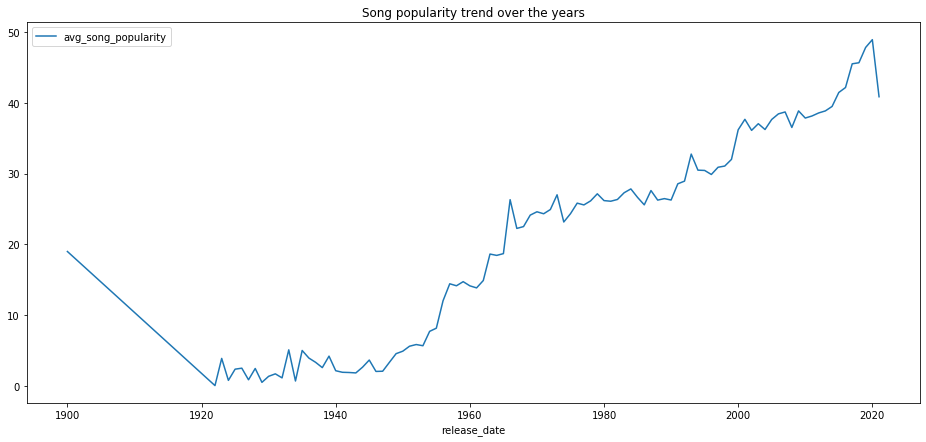

In [14]:
song_popularity=df.groupBy("release_date").agg(round(avg("track_popularity"),2).alias("avg_song_popularity")).sort(desc("release_date"))
song_popularity.show(truncate=False)

song_popularity.toPandas().plot(x="release_date", y="avg_song_popularity", kind="line",title="Song popularity trend over the years",figsize=(16,7))


### ii).Song Release trend over years

+------------+-----+
|release_date|count|
+------------+-----+
|2021        |2803 |
|2020        |6669 |
|2019        |6702 |
|2018        |6595 |
|2017        |6234 |
|2016        |7323 |
|2015        |7044 |
|2014        |7713 |
|2013        |7321 |
|2012        |7169 |
|2011        |7263 |
|2010        |7385 |
|2009        |7525 |
|2008        |7838 |
|2007        |7133 |
|2006        |7032 |
|2005        |7134 |
|2004        |7502 |
|2003        |6733 |
|2002        |7318 |
+------------+-----+
only showing top 20 rows



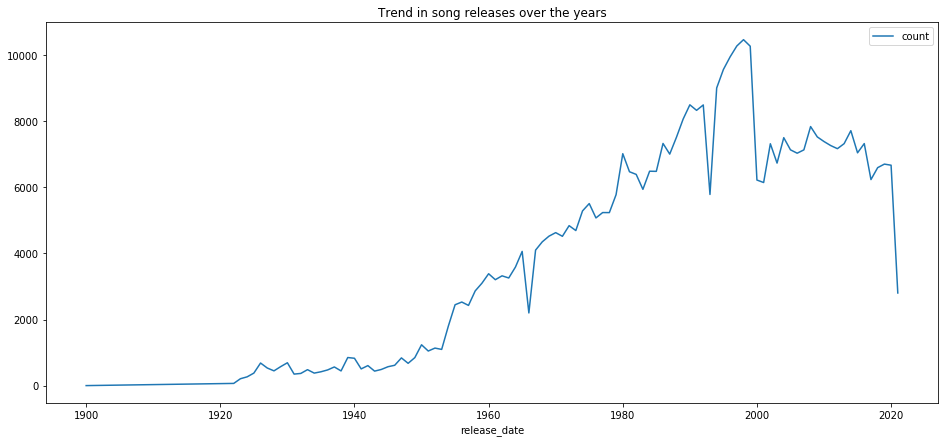

In [15]:
songs=df.groupBy("release_date").count().sort(desc("release_date"))
songs.show(truncate=False)

songs.toPandas().plot(x="release_date", y="count", kind="line",title="Trend in song releases over the years",figsize=(16,7))

## 2.Which Genres and artists are more popular

### i) Popular Genres

+---------------------+-----+
|genres               |count|
+---------------------+-----+
|adult standards      |22529|
|album rock           |16188|
|hoerspiel            |10423|
|c-pop                |8640 |
|latin                |6254 |
|classic bollywood    |5863 |
|chanson              |5170 |
|classic swedish pop  |4874 |
|dance pop            |4868 |
|classic israeli pop  |4752 |
|bossa nova           |4588 |
|alternative metal    |4190 |
|alternative rock     |3903 |
|bebop                |3900 |
|argentine rock       |3858 |
|j-pop                |3702 |
|classic italian pop  |3176 |
|classic icelandic pop|3111 |
|classic finnish pop  |3110 |
|art rock             |3065 |
+---------------------+-----+
only showing top 20 rows



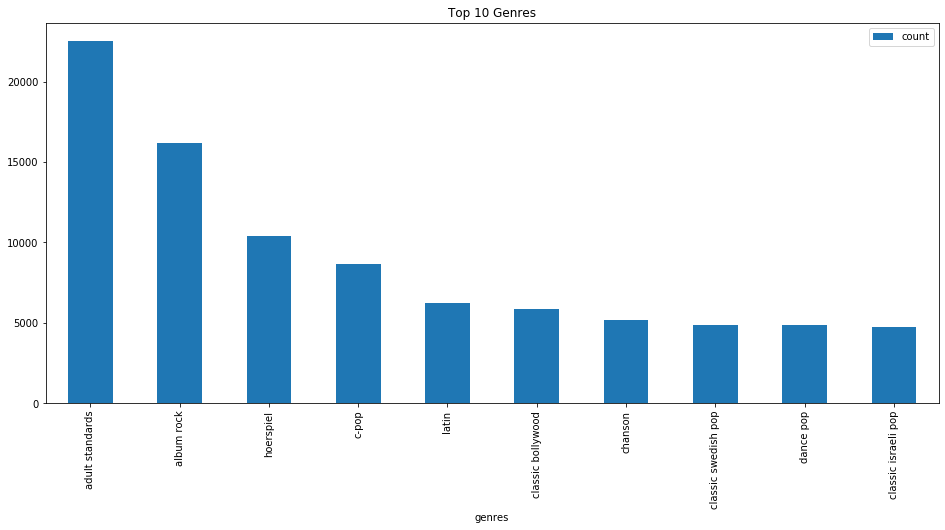

In [16]:
df3=df.groupBy("genres").count().sort(desc("count"))
df3.show(truncate=False)

pandasDF=df3.limit(10).toPandas()
fig=pandasDF.plot(x="genres", y="count", kind="bar",figsize=(16,7))
plt.title("Top 10 Genres")
fig

#df01 = spark.read.format("com.mongodb.spark.sql.DefaultSource").option("database","lab2").option("collection", "Employee_data").load()
#df01.show(1)

### ii. All time Popular artists

+--------------+---------------------+
|   artist_name|avg_artist_popularity|
+--------------+---------------------+
|   Myke Towers|                 95.0|
|  taiwan indie|                94.74|
|     Pop Smoke|                 92.0|
|        Polo G|                 91.0|
|  Die drei ???|                 90.0|
| The Kid LAROI|                 90.0|
|      24kGoldn|                 87.0|
|Anderson .Paak|                 86.0|
|   Alan Walker|                 85.0|
|       ROSALÍA|                 85.0|
+--------------+---------------------+
only showing top 10 rows



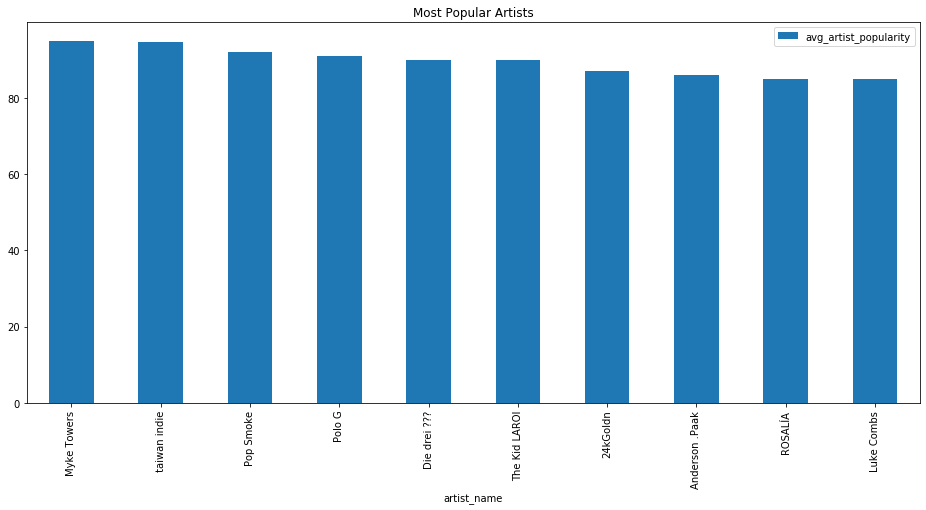

In [17]:
artist_popularity=df.groupBy("artist_name").agg(round(avg("artist_popularity"),2).alias("avg_artist_popularity"))
artist_popularity=artist_popularity.filter(artist_popularity.avg_artist_popularity<='100')

#Writing to DB
artist_popularity.write.format('mongo')\
        .mode("overwrite")\
        .option( "uri", "mongodb://localhost:27017/ece552_team17.popular_artists") \
        .save()

### Reading from DB and plotting
#.filter(df.release_date >= "2000")

df01 = spark.read.format("com.mongodb.spark.sql.DefaultSource").option("database","ece552_team17").option("collection", "popular_artists").load()
df2=df01.drop("_id").sort(desc("avg_artist_popularity"))
df2.show(10)


df2.limit(10).toPandas().plot(x="artist_name",y="avg_artist_popularity",kind="bar", title="Most Popular Artists",figsize=(16,7))


## 3.Which music genres are influencing the public most? 

+-----------------+---------------+
|genres           |total_followers|
+-----------------+---------------+
|album rock       |41976.098      |
|pop              |35563.598      |
|dance pop        |30367.63       |
|classic rock     |29630.115      |
|latin            |22734.799      |
|adult standards  |21366.607      |
|k-pop            |12386.771      |
|alternative metal|12010.894      |
|canadian pop     |10950.572      |
|beatlesque       |10630.498      |
|alternative rock |9624.755       |
|classic bollywood|7723.6294      |
|british invasion |6589.5234      |
|hard rock        |6329.127       |
|sertanejo        |6292.7007      |
|detroit hip hop  |6291.172       |
|canadian hip hop |5651.537       |
|modern rock      |5486.1606      |
|bolero           |4805.8545      |
|desi pop         |4365.4526      |
+-----------------+---------------+
only showing top 20 rows



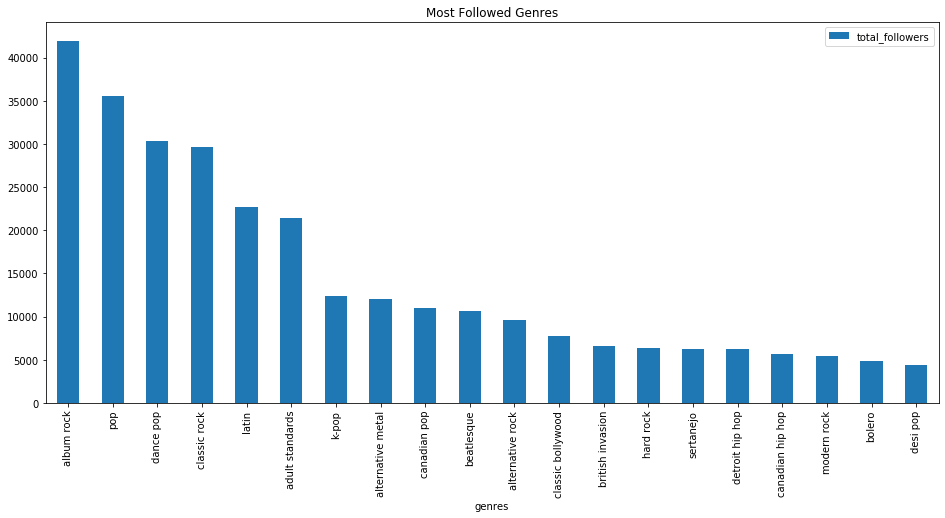

In [18]:
artist_followers=df.groupBy("genres").agg((sum("followers")/1000000).alias("total_followers")).sort(desc("total_followers"))
artist_followers=artist_followers.withColumn('total_followers', artist_followers.total_followers.cast('float'))
artist_followers.show(truncate=False)

artist_followers.limit(20).toPandas().plot(x="genres",
                                           y="total_followers",
                                           kind="bar",
                                           title="Most Followed Genres",figsize=(16,7))


## 4.What proportion of songs released are Explicit 

+--------+-----------+-----------------+
|explicit|group_count|Explicit(%)      |
+--------+-----------+-----------------+
|0.0     |415347     |96.3228456202763 |
|1.0     |15856      |3.677154379723703|
+--------+-----------+-----------------+



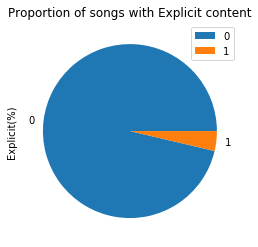

In [19]:
import pyspark.sql.functions as f
from pyspark.sql.window import Window


explicit_prop=df.groupBy("explicit") \
  .count() \
  .withColumnRenamed('count', 'group_count') \
  .withColumn('Explicit(%)', (f.col('group_count') / df.count()) * 100 )

explicit_prop.show(truncate=False)

explicit_prop.toPandas().plot(kind='pie', y='Explicit(%)', title="Proportion of songs with Explicit content")

# Task 3:Machine Learning Modelling

## Feature Engineering

### Converting categorical data to indexes

In [20]:
from pyspark.ml.feature import StringIndexer
genre_index = StringIndexer(inputCol="genres", outputCol="genresIndex")
#Fits a model to the input dataset with optional parameters.
df = genre_index.fit(df).transform(df)

### Extracting numerical columns

In [21]:
#df = spark.read.parquet("spotify_ml.parquet")
df=df.withColumn("release_date",df.release_date.cast('int'))
df=df.withColumn('High_Popularity', f.when(f.col('track_popularity') > 55, "1").otherwise("0"))
df=df.withColumn("High_Popularity",df.High_Popularity.cast('int'))

numeric_columns = [column[0] for column in df.dtypes if column[1]=='int' or column[1]=='float' or column[1]=='double']
numeric_columns

['followers',
 'artist_popularity',
 'track_popularity',
 'duration_ms',
 'explicit',
 'release_date',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'genresIndex',
 'High_Popularity']

In [22]:
songs_df=df[numeric_columns]
songs_df=songs_df.drop("track_popularity")

In [23]:
songs_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
followers,431203,1129717.646298843,3895894.0615830943,0,78900234
artist_popularity,431203,39.85238043334578,30.6338365222956,0.0,5566.0
duration_ms,431203,228047.42245299777,111314.82147273255,3344.0,4995083.0
explicit,431203,0.03677154379723703,0.18820063630360956,0.0,1.0
release_date,431203,1989.9592164247465,20.02446965643562,1900,2021
danceability,431203,0.564794301110065,0.15876494682205539,0.0,0.9909999966621399
energy,431203,0.5629860435106407,0.2418301137583711,0.0,1.0
key,431203,5.234689925626677,3.5193540695767336,0.0,11.0
loudness,431203,-9.737432888568078,4.509405100504198,-60.0,5.375999927520752


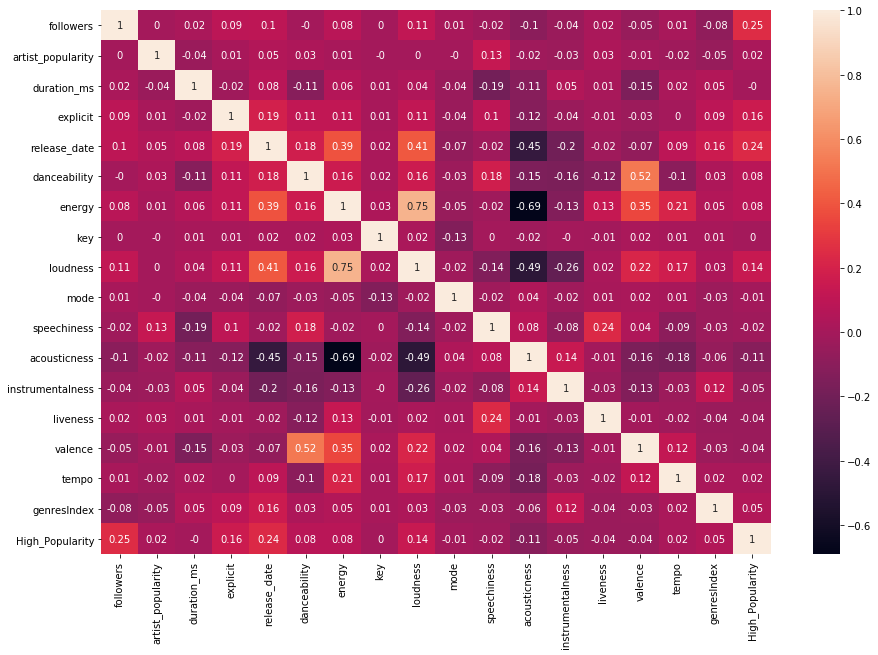

In [24]:
fig, ax = plt.subplots(figsize=(15,10))  
matrix = songs_df.toPandas().corr().round(2)
sns.heatmap(matrix, annot=True)
plt.show()

### Selecting the features 

In [25]:
feature_columns = ['explicit','release_date','loudness','followers']
label_column = 'High_Popularity'
vector_assembler = VectorAssembler(inputCols = feature_columns, outputCol = 'features')
song_features_df = vector_assembler.transform(songs_df).select(['features', label_column])

### Test-Train split

In [26]:
train_df, test_df = song_features_df.randomSplit([0.70, 0.30], seed=10)
train_df.count(), test_df.count()

(301796, 129407)

## i) Logistic Regression

In [27]:
# (7) Train a Logistic Regression Model on the Training DataFrame
logistic_regression = LogisticRegression(featuresCol = 'features', labelCol = label_column)
logistic_regression_model = logistic_regression.fit(train_df)

In [28]:
# (9) Apply the Trained Logistic Regression Model to the Test DataFrame to make predictions
test_logistic_regression_predictions_df = logistic_regression_model.transform(test_df)
print("TEST DATASET PREDICTIONS AGAINST ACTUAL LABEL: ")
test_logistic_regression_predictions_df.select("probability", "rawPrediction", "prediction", label_column, "features").show(5)

TEST DATASET PREDICTIONS AGAINST ACTUAL LABEL: 
+--------------------+--------------------+----------+---------------+--------------------+
|         probability|       rawPrediction|prediction|High_Popularity|            features|
+--------------------+--------------------+----------+---------------+--------------------+
|[0.92949495639866...|[2.57895713329843...|       0.0|              0|[0.0,1924.0,-17.5...|
|[0.92934937986905...|[2.57673786318017...|       0.0|              0|[0.0,1924.0,-16.6...|
|[0.92861840028131...|[2.56565776135516...|       0.0|              0|[0.0,1926.0,-12.4...|
|[0.92956283115483...|[2.57999331121147...|       0.0|              0|[0.0,1927.0,-17.9...|
|[0.93020054504695...|[2.58977400169367...|       0.0|              0|[0.0,1929.0,-21.5...|
+--------------------+--------------------+----------+---------------+--------------------+
only showing top 5 rows



In [29]:
evaluator_roc_area = BinaryClassificationEvaluator(rawPredictionCol = "rawPrediction", labelCol = label_column, metricName = "areaUnderROC")
print("Area Under ROC Curve on Test Data = %g" % evaluator_roc_area.evaluate(test_logistic_regression_predictions_df))

evaluator = MulticlassClassificationEvaluator(labelCol="High_Popularity", predictionCol="prediction",metricName="accuracy")
accuracy = evaluator.evaluate(test_logistic_regression_predictions_df)
print("Test Error = %g " % (1.0 - accuracy))
print("Accuracy = %g " % accuracy)

Area Under ROC Curve on Test Data = 0.774293
Test Error = 0.0731954 
Accuracy = 0.926805 


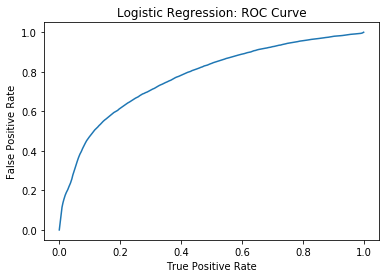

In [30]:
test_summary = logistic_regression_model.evaluate(test_df)
roc = test_summary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('Logistic Regression: ROC Curve')
plt.show()

## ii) Decision Trees

In [31]:
decision_tree = DecisionTreeClassifier(featuresCol = 'features', labelCol = label_column)
decision_tree_model = decision_tree.fit(train_df)

In [32]:
test_decision_tree_predictions_df = decision_tree_model.transform(test_df)
print("TEST DATASET PREDICTIONS AGAINST ACTUAL LABEL: ")
test_decision_tree_predictions_df.select("probability", "rawPrediction", "prediction", label_column, "features").show(5)

TEST DATASET PREDICTIONS AGAINST ACTUAL LABEL: 
+--------------------+-----------------+----------+---------------+--------------------+
|         probability|    rawPrediction|prediction|High_Popularity|            features|
+--------------------+-----------------+----------+---------------+--------------------+
|[0.97955725183426...|[201731.0,4210.0]|       0.0|              0|[0.0,1924.0,-17.5...|
|[0.97955725183426...|[201731.0,4210.0]|       0.0|              0|[0.0,1924.0,-16.6...|
|[0.97955725183426...|[201731.0,4210.0]|       0.0|              0|[0.0,1926.0,-12.4...|
|[0.97955725183426...|[201731.0,4210.0]|       0.0|              0|[0.0,1927.0,-17.9...|
|[0.97955725183426...|[201731.0,4210.0]|       0.0|              0|[0.0,1929.0,-21.5...|
+--------------------+-----------------+----------+---------------+--------------------+
only showing top 5 rows



In [33]:
evaluator_roc_area = BinaryClassificationEvaluator(rawPredictionCol = "rawPrediction", labelCol = label_column, metricName = "areaUnderROC")
print("Area Under ROC Curve on Test Data = %g" % evaluator_roc_area.evaluate(test_decision_tree_predictions_df))

evaluator = MulticlassClassificationEvaluator(labelCol="High_Popularity", predictionCol="prediction",metricName="accuracy")
accuracy = evaluator.evaluate(test_decision_tree_predictions_df)
print("Test Error = %g " % (1.0 - accuracy))
print("Accuracy = %g " % accuracy)

Area Under ROC Curve on Test Data = 0.195719
Test Error = 0.0674152 
Accuracy = 0.932585 


## iii) Random Forest

In [34]:
random_forest = RandomForestClassifier(featuresCol = 'features', labelCol = label_column)
random_forest_model = random_forest.fit(train_df)

In [35]:
# (12) Apply the Trained Random Forest Classifier Model to the Test DataFrame to make predictions
test_random_forest_predictions_df = random_forest_model.transform(test_df)
print("TEST DATASET PREDICTIONS AGAINST ACTUAL LABEL: ")
test_random_forest_predictions_df.select("probability", "rawPrediction", "prediction", label_column, "features").show(5)

TEST DATASET PREDICTIONS AGAINST ACTUAL LABEL: 
+--------------------+--------------------+----------+---------------+--------------------+
|         probability|       rawPrediction|prediction|High_Popularity|            features|
+--------------------+--------------------+----------+---------------+--------------------+
|[0.97287132186653...|[19.4574264373307...|       0.0|              0|[0.0,1924.0,-17.5...|
|[0.97287132186653...|[19.4574264373307...|       0.0|              0|[0.0,1924.0,-16.6...|
|[0.97287132186653...|[19.4574264373307...|       0.0|              0|[0.0,1926.0,-12.4...|
|[0.97287132186653...|[19.4574264373307...|       0.0|              0|[0.0,1927.0,-17.9...|
|[0.97309348159072...|[19.4618696318144...|       0.0|              0|[0.0,1929.0,-21.5...|
+--------------------+--------------------+----------+---------------+--------------------+
only showing top 5 rows



In [36]:
# (13) Evaluate the performance of our Random Forest Classifier Model on the Test DataFrame using Area under a ROC curve
evaluator_rf_roc_area = BinaryClassificationEvaluator(rawPredictionCol = "rawPrediction", labelCol = label_column, metricName = "areaUnderROC")
print("Area Under ROC Curve on Test Data = %g" % evaluator_rf_roc_area.evaluate(test_random_forest_predictions_df))

evaluator = MulticlassClassificationEvaluator(labelCol="High_Popularity", predictionCol="prediction",metricName="accuracy")
accuracy = evaluator.evaluate(test_random_forest_predictions_df)
print("Test Error = %g " % (1.0 - accuracy))
print("Accuracy = %g " % accuracy)

Area Under ROC Curve on Test Data = 0.860968
Test Error = 0.0694476 
Accuracy = 0.930552 


## Feature Importance

In [37]:
pd.set_option('display.max_rows', None)
feature_imp = pd.DataFrame(list(zip(vector_assembler.getInputCols(), random_forest_model.featureImportances)), columns = ['column', 'weight']).sort_values('weight',ascending=False)

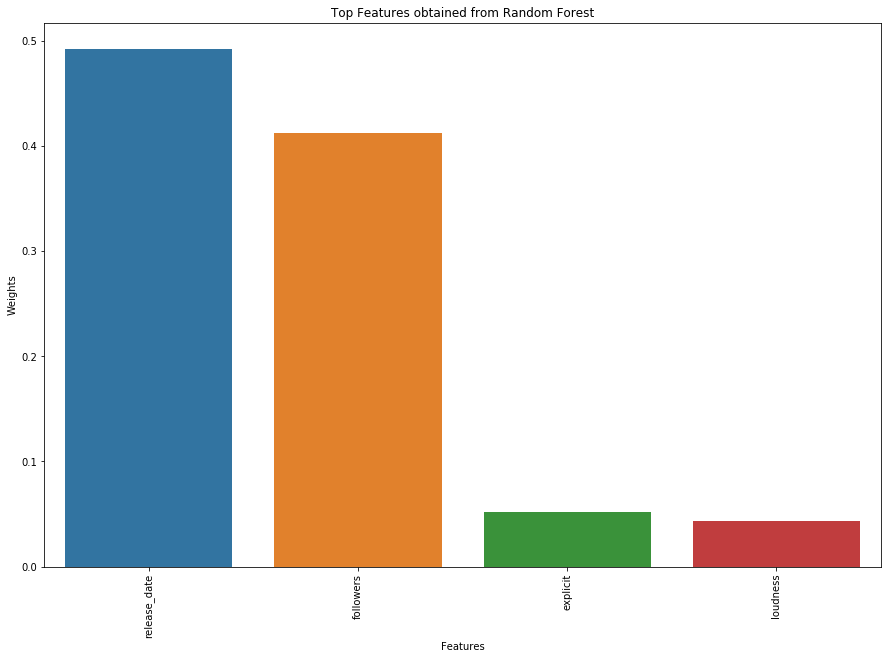

In [39]:
plt.figure(figsize=(15,10))
sns.barplot(x=feature_imp['column'][:5], y=feature_imp['weight'][:5],data=feature_imp)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Weights")
plt.title("Top Features obtained from Random Forest");

#           &nbsp;   &nbsp; &nbsp; &nbsp; &nbsp;   &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;   &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;                                           ------The End------